In [21]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import fitz
from sklearn.decomposition import PCA
import plotly.express as px
import os
import string
from unidecode import unidecode
import numpy as np
import sys
sys.path.append("..")
from analise_recomendacao.bd import nova_conexao
from psycopg2.errors import ProgrammingError
import sys
from utilitários import calcular_idade
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Conteúdo
#### 1. [Obtenção dos dados](#1)
#### 2. [Pré-processamento dos dados](#2)
#### 3. [Análise exploratória dos dados](#3)

---
 ### **<a id =1></a> Obtenção dos dados**

In [22]:
# Obtendo os currículos e os colocando em um dataframe
diretório = '../curriculos/'
filenames = []
curriculos = []
for filename in os.listdir(diretório):
    filenames.append(filename)
    curriculo_path = os.path.join(diretório, filename)

    reader = fitz.open(curriculo_path)
    text = []
    for page in reader:
        text.append(page.get_text())
    text = " ".join(text).replace("\n", " ")
    curriculos.append(text)

df_curriculos = pd.DataFrame(
    {
        'filenames' : filenames,
        'curriculos' : curriculos
    })
df_curriculos['curriculos'][10]


'Nome: Rafaela Santos Endereço: Avenida das Palmeiras, 456 - Cidade Serena, Estado Y Telefone: (00) 9876-5432 E-mail: rafaela.santos@email.com Objetivo: Busco oportunidade como Analista de Pesquisa em Biotecnologia para ampliar meus conhecimentos em análises bioquímicas, biológicas e microbiológicas em laboratório, e contribuir com a equipe em projetos de pesquisa. Formação Acadêmica: Bacharelado em Biotecnologia - Universidade Estadual de Estado Y (2018-2022) Experiência Profissional: Estagiária de Laboratório - Laboratório de Biotecnologia Aplicada - Cidade Serena, Estado Y (2022-2023) Auxiliei nas análises bioquímicas, biológicas e microbiológicas em amostras de pesquisa. Realizei tarefas de rotina, como preparação de soluções e manutenção do laboratório. Colaborei em projetos de pesquisa, seguindo as orientações da equipe. Habilidades: Familiaridade com técnicas de análises bioquímicas, biológicas e microbiológicas. Conhecimento básico em biotecnologia, microbiologia e biologia mol

In [23]:
# Obtendo as vagas e colocando-as em um dataframe
sql_select_datas = "select texto, cargo from emprega_vaga_analise order by id"
textos = []
cargos = []
with nova_conexao() as conexao:
    try:
        cursor = conexao.cursor()
        cursor.execute(sql_select_datas)
        resultado = cursor.fetchall()
    except ProgrammingError as e:
        print(f'Erro: {e.msg}')
    else:
        for row in resultado:
            textos.append(row[0])
            cargos.append(row[1])
        conexao.commit()

df_vagas = pd.DataFrame(
    {
        'cargos' : cargos,
        'textos' : textos
    })

df_vagas['textos'][1]

'Desenvolvedor Java Desenvolvimento de sistemas web utilizando a linguagem Java e o framework Spring Boot; Integração com bancos de dados relacionais e NoSQL; Implementação de testes automatizados; Participação em reuniões de planejamento e discussão de requisitos com o time de produto. Graduação em Ciência da Computação ou áreas correlatas; Experiência com desenvolvimento Java e Spring Boot; Conhecimento em bancos de dados relacionais e NoSQL; Familiaridade com testes automatizados. Tecnologia da Informação A Empresa de Tecnologia LTDA é líder no mercado de desenvolvimento de soluções tecnológicas, com mais de 10 anos de experiência na área.'

In [24]:
# Obtendo as idades
sql_select_datas = "select data_nascimento from emprega_usuario_analise order by id"
idades = []
with nova_conexao() as conexao:
    try:
        cursor = conexao.cursor()
        cursor.execute(sql_select_datas)
        resultado = cursor.fetchall()
    except ProgrammingError as e:
        print(f'Erro: {e.msg}')
    else:
        for row in resultado:
            idades.append(calcular_idade(str(row[0])))
        conexao.commit()
idades = sorted(idades)
media = round(statistics.mean(idades))
mediana = statistics.median(idades)
moda = statistics.mode(idades)
desvio = round(np.std(idades))
print(idades)

[17, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 40, 40, 40, 40, 41, 41, 42, 43, 44, 49]


---
 ### **<a id =2></a> Pré-processamento dos dados**

In [25]:
# Pre-processamento do texto

# LowerCase
df_curriculos['curriculos'] = [curriculo.lower() for curriculo in df_curriculos['curriculos']]
df_vagas['textos'] = [vaga.lower() for vaga in df_vagas['textos']]

# Remoção de pontuação e símbolos
# Tabela de pontuação
punctuation = string.punctuation
# Criar tabela de tradução que susbstituirá toda pontuação por um espaço em branco
trantab = str.maketrans(punctuation, len(punctuation)*' ')
# Traduzir nosso exemplo
df_curriculos['curriculos'] = [curriculo.translate(trantab) for curriculo in df_curriculos['curriculos']]
df_vagas['textos'] = [vaga.translate(trantab) for vaga in df_vagas['textos']]

# Remover caracteres especiais (acentos e afins)
df_curriculos['curriculos'] = [unidecode(curriculo) for curriculo in df_curriculos['curriculos']]
df_vagas['textos'] = [unidecode(vaga) for vaga in df_vagas['textos']]

print(df_curriculos['curriculos'][10])
print(df_vagas['textos'][1])


nome  rafaela santos endereco  avenida das palmeiras  456   cidade serena  estado y telefone   00  9876 5432 e mail  rafaela santos email com objetivo  busco oportunidade como analista de pesquisa em biotecnologia para ampliar meus conhecimentos em analises bioquimicas  biologicas e microbiologicas em laboratorio  e contribuir com a equipe em projetos de pesquisa  formacao academica  bacharelado em biotecnologia   universidade estadual de estado y  2018 2022  experiencia profissional  estagiaria de laboratorio   laboratorio de biotecnologia aplicada   cidade serena  estado y  2022 2023  auxiliei nas analises bioquimicas  biologicas e microbiologicas em amostras de pesquisa  realizei tarefas de rotina  como preparacao de solucoes e manutencao do laboratorio  colaborei em projetos de pesquisa  seguindo as orientacoes da equipe  habilidades  familiaridade com tecnicas de analises bioquimicas  biologicas e microbiologicas  conhecimento basico em biotecnologia  microbiologia e biologia mole

In [26]:
# Pre-processamento do texto

# Preparar para remoção de stopwords e radicalização/lematização
df_curriculos['curriculos'] = [curriculo.split() for curriculo in df_curriculos['curriculos']]
df_vagas['textos'] = [vaga.split() for vaga in df_vagas['textos']]
print(df_curriculos['curriculos'][10])
print(df_vagas['textos'][1])


['nome', 'rafaela', 'santos', 'endereco', 'avenida', 'das', 'palmeiras', '456', 'cidade', 'serena', 'estado', 'y', 'telefone', '00', '9876', '5432', 'e', 'mail', 'rafaela', 'santos', 'email', 'com', 'objetivo', 'busco', 'oportunidade', 'como', 'analista', 'de', 'pesquisa', 'em', 'biotecnologia', 'para', 'ampliar', 'meus', 'conhecimentos', 'em', 'analises', 'bioquimicas', 'biologicas', 'e', 'microbiologicas', 'em', 'laboratorio', 'e', 'contribuir', 'com', 'a', 'equipe', 'em', 'projetos', 'de', 'pesquisa', 'formacao', 'academica', 'bacharelado', 'em', 'biotecnologia', 'universidade', 'estadual', 'de', 'estado', 'y', '2018', '2022', 'experiencia', 'profissional', 'estagiaria', 'de', 'laboratorio', 'laboratorio', 'de', 'biotecnologia', 'aplicada', 'cidade', 'serena', 'estado', 'y', '2022', '2023', 'auxiliei', 'nas', 'analises', 'bioquimicas', 'biologicas', 'e', 'microbiologicas', 'em', 'amostras', 'de', 'pesquisa', 'realizei', 'tarefas', 'de', 'rotina', 'como', 'preparacao', 'de', 'solucoe

In [27]:
# Pre-processamento do texto

# Remover stopwords
try:
    stopwords_list = stopwords.words('portuguese')
except:
    nltk.download('stopwords')
    stopwords_list = stopwords.words('portuguese')

for index, curriculo in enumerate(df_curriculos['curriculos']):
    curriculo = [palavra for palavra in curriculo if (
        palavra not in stopwords_list) and len(palavra) > 1]
    df_curriculos['curriculos'][index] = curriculo

for index, vaga in enumerate(df_vagas['textos']):
    vaga = [palavra for palavra in vaga if (
        palavra not in stopwords_list) and len(palavra) > 1]
    df_vagas['textos'][index] = vaga

print(df_curriculos['curriculos'][10])
print(df_vagas['textos'][1])


['nome', 'rafaela', 'santos', 'endereco', 'avenida', 'palmeiras', '456', 'cidade', 'serena', 'estado', 'telefone', '00', '9876', '5432', 'mail', 'rafaela', 'santos', 'email', 'objetivo', 'busco', 'oportunidade', 'analista', 'pesquisa', 'biotecnologia', 'ampliar', 'conhecimentos', 'analises', 'bioquimicas', 'biologicas', 'microbiologicas', 'laboratorio', 'contribuir', 'equipe', 'projetos', 'pesquisa', 'formacao', 'academica', 'bacharelado', 'biotecnologia', 'universidade', 'estadual', 'estado', '2018', '2022', 'experiencia', 'profissional', 'estagiaria', 'laboratorio', 'laboratorio', 'biotecnologia', 'aplicada', 'cidade', 'serena', 'estado', '2022', '2023', 'auxiliei', 'analises', 'bioquimicas', 'biologicas', 'microbiologicas', 'amostras', 'pesquisa', 'realizei', 'tarefas', 'rotina', 'preparacao', 'solucoes', 'manutencao', 'laboratorio', 'colaborei', 'projetos', 'pesquisa', 'seguindo', 'orientacoes', 'equipe', 'habilidades', 'familiaridade', 'tecnicas', 'analises', 'bioquimicas', 'biolo

In [28]:
# Pre-processamento do texto
import pandas as pd
# Lematização
import spacy
nlp = spacy.load('pt_core_news_sm')
docs_curriculo = []
docs_vaga = []
lemma_curriculos = []
lemma_vagas = []

for index, curriculo in enumerate(df_curriculos['curriculos']):
    docs_curriculo.append(nlp(str([palavra for palavra in curriculo])))
    lemma_curriculos.append(" ".join([token.lemma_ for token in docs_curriculo[index] if token.pos_ != 'PUNCT'
                                      and token.lemma_ != "'"]))

for index, vaga in enumerate(df_vagas['textos']):
    docs_vaga.append(nlp(str([palavra for palavra in vaga])))
    lemma_vagas.append(" ".join([token.lemma_ for token in docs_vaga[index] if token.pos_ != 'PUNCT'
                                      and token.lemma_ != "'"]))

df_curriculos['curriculos_lemma'] = lemma_curriculos
df_vagas['textos_lemma'] = lemma_vagas
df_vagas['textos'][1]

['desenvolvedor',
 'java',
 'desenvolvimento',
 'sistemas',
 'web',
 'utilizando',
 'linguagem',
 'java',
 'framework',
 'spring',
 'boot',
 'integracao',
 'bancos',
 'dados',
 'relacionais',
 'nosql',
 'implementacao',
 'testes',
 'automatizados',
 'participacao',
 'reunioes',
 'planejamento',
 'discussao',
 'requisitos',
 'time',
 'produto',
 'graduacao',
 'ciencia',
 'computacao',
 'areas',
 'correlatas',
 'experiencia',
 'desenvolvimento',
 'java',
 'spring',
 'boot',
 'conhecimento',
 'bancos',
 'dados',
 'relacionais',
 'nosql',
 'familiaridade',
 'testes',
 'automatizados',
 'tecnologia',
 'informacao',
 'empresa',
 'tecnologia',
 'ltda',
 'lider',
 'mercado',
 'desenvolvimento',
 'solucoes',
 'tecnologicas',
 '10',
 'anos',
 'experiencia',
 'area']

In [29]:
# Pre-processamento do texto

# Stemming
nltk.download('rslp', quiet=True)
rslps = nltk.stem.RSLPStemmer()
stemmings_curriculos = []
stemmings_vagas = []

for index, curriculo in enumerate(df_curriculos['curriculos']):
    curriculo = " ".join([rslps.stem(palavra) for palavra in curriculo])
    stemmings_curriculos.append(curriculo)

for index, vaga in enumerate(df_vagas['textos']):
    vaga = " ".join([rslps.stem(palavra) for palavra in vaga])
    stemmings_vagas.append(vaga)

df_curriculos['curriculos_stem'] = stemmings_curriculos
df_vagas['textos_stem'] = stemmings_vagas

print(df_curriculos['curriculos'][10])
print(df_curriculos['curriculos_lemma'][10])
print(df_curriculos['curriculos_stem'][10])
print(df_vagas['textos'][1])
print(df_vagas['textos_lemma'][1])
print(df_vagas['textos_stem'][1])

['nome', 'rafaela', 'santos', 'endereco', 'avenida', 'palmeiras', '456', 'cidade', 'serena', 'estado', 'telefone', '00', '9876', '5432', 'mail', 'rafaela', 'santos', 'email', 'objetivo', 'busco', 'oportunidade', 'analista', 'pesquisa', 'biotecnologia', 'ampliar', 'conhecimentos', 'analises', 'bioquimicas', 'biologicas', 'microbiologicas', 'laboratorio', 'contribuir', 'equipe', 'projetos', 'pesquisa', 'formacao', 'academica', 'bacharelado', 'biotecnologia', 'universidade', 'estadual', 'estado', '2018', '2022', 'experiencia', 'profissional', 'estagiaria', 'laboratorio', 'laboratorio', 'biotecnologia', 'aplicada', 'cidade', 'serena', 'estado', '2022', '2023', 'auxiliei', 'analises', 'bioquimicas', 'biologicas', 'microbiologicas', 'amostras', 'pesquisa', 'realizei', 'tarefas', 'rotina', 'preparacao', 'solucoes', 'manutencao', 'laboratorio', 'colaborei', 'projetos', 'pesquisa', 'seguindo', 'orientacoes', 'equipe', 'habilidades', 'familiaridade', 'tecnicas', 'analises', 'bioquimicas', 'biolo

---
 ### **<a id =3></a> Análise exploratória dos dados**

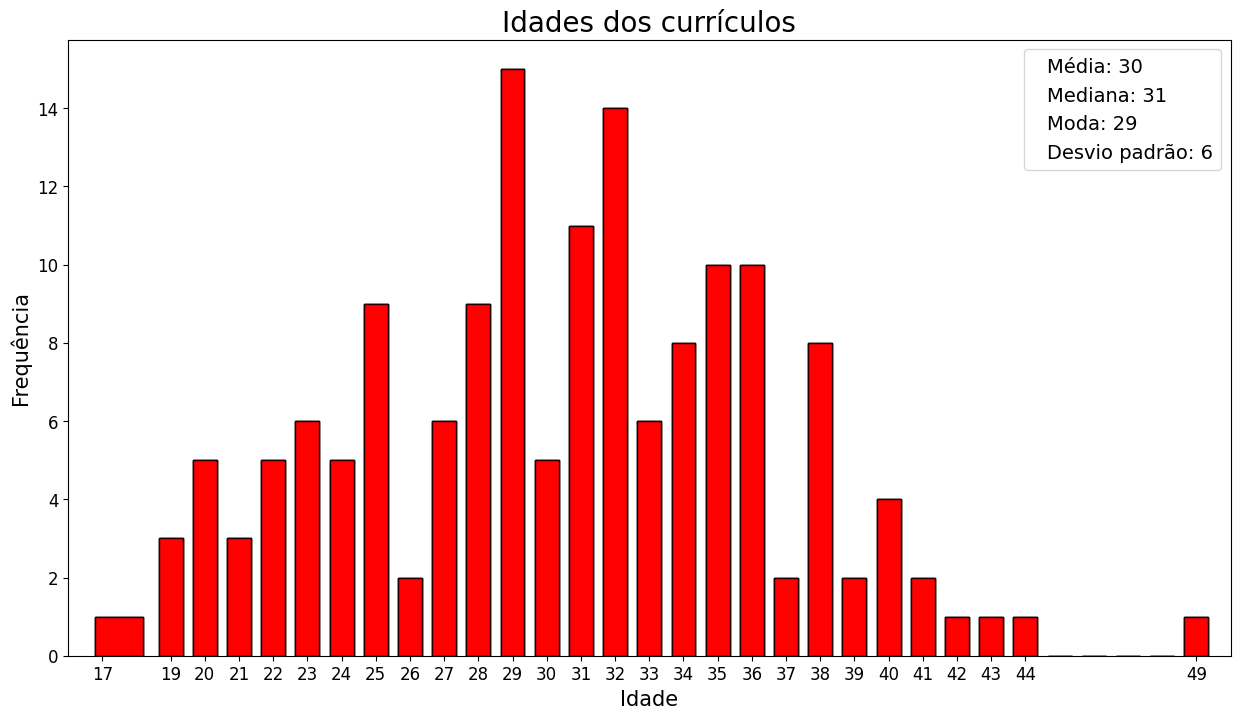

In [30]:
#Distribuição das idades 

idades_unicas = np.unique(idades)
bins = idades_unicas-0.5

bins = bins.tolist()
del(bins[-1])
bins.append(44.5)
bins.append(45.5)
bins.append(46.5)
bins.append(47.5)
bins.append(48.5)
bins.append(49.5)

plt.figure(figsize=(15, 8), dpi=100)
plt.title('Idades dos currículos', fontsize=20)
plt.xlabel('Idade', fontsize=15)
plt.ylabel('Frequência', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(idades_unicas)
plt.xlim([min(idades_unicas)-1, max(idades_unicas)+1])
plt.hist(idades, rwidth=0.7, bins=bins, color='red', alpha=0.7, edgecolor='black', label=f'Média: {media}')
plt.hist(idades, rwidth=0.7, bins=bins, color='red', alpha=0.7, edgecolor='black', label=f'Mediana: {mediana}')
plt.hist(idades, rwidth=0.7, bins=bins, color='red', alpha=0.7, edgecolor='black', label=f'Moda: {moda}')
plt.hist(idades, rwidth=0.7, bins=bins, color='red', alpha=0.7, edgecolor='black', label=f'Desvio padrão: {desvio}')
leg = plt.legend(handlelength=0, fancybox=True, fontsize="14")
for item in leg.legend_handles:
    item.set_visible(False)
plt.show()

[Text(0.0, 0, 'empresa'),
 Text(1.0, 0, 'experiencia'),
 Text(2.0, 0, 'desenvolvimento'),
 Text(3.0, 0, 'realizar'),
 Text(4.0, 0, 'projetos'),
 Text(5.0, 0, 'analise'),
 Text(6.0, 0, 'areas'),
 Text(7.0, 0, 'conhecimento'),
 Text(8.0, 0, 'ltda'),
 Text(9.0, 0, 'formacao')]

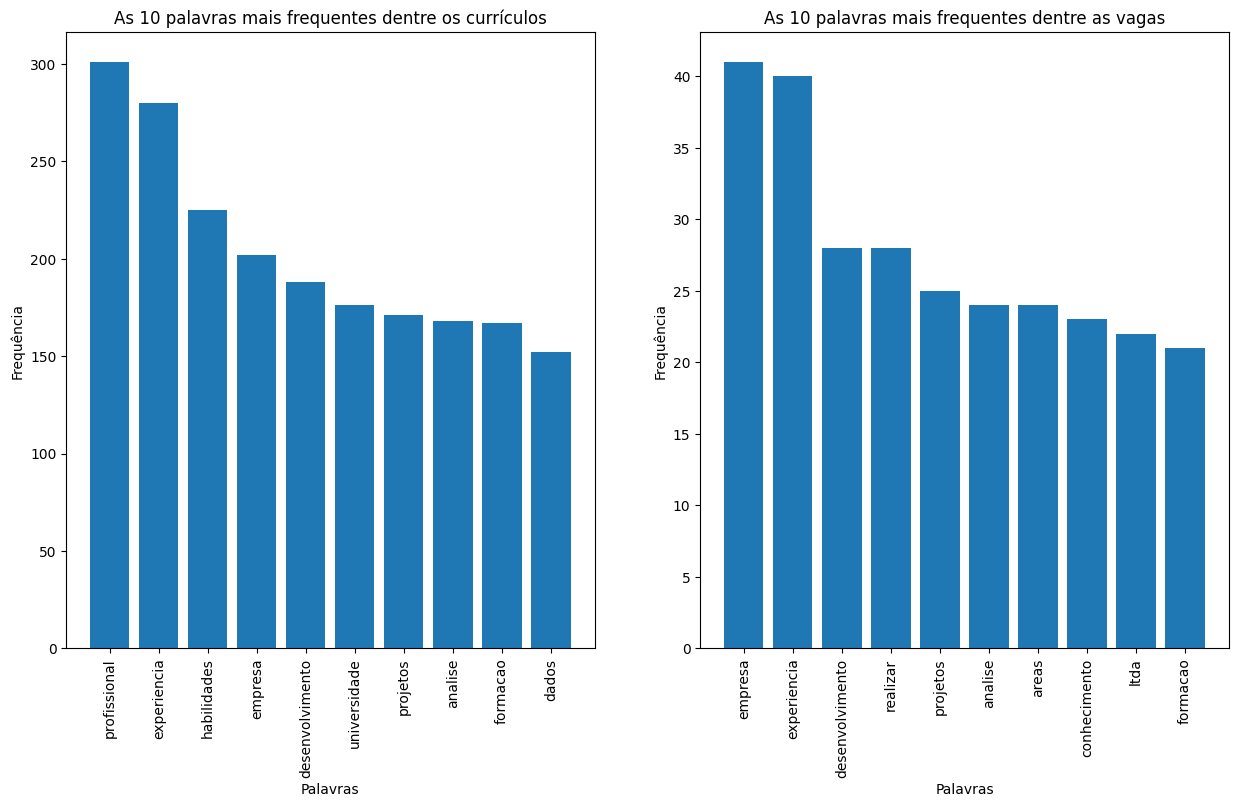

In [31]:
# Histograma da contagem de palavras mais frequentes

# Assign the Counter instance `most_common` call to a variable:
# É necessário fazer um " ".join(curriculos[i]) para que cada elemento da lista seja uma string inteira do currículo
# Sem fazer a lista de currículos é uma lista contendo várias listas, pois cada palavra do currículo é uma lista em si.
# Por isso o list comprehension dentro do primeiro join dentro do Counter
word_frequency_curriculos = Counter(" ".join(
    [" ".join(curriculo) for curriculo in df_curriculos['curriculos']]).split()).most_common(10)

word_frequency_vagas = Counter(" ".join(
    [" ".join(vaga) for vaga in df_vagas['textos']]).split()).most_common(10)

# `most_common` returns a list of (word, count) tuples
words_curriculos = [word for word, _ in word_frequency_curriculos]
counts_curriculos = [counts for _, counts in word_frequency_curriculos]
words_vagas = [word for word, _ in word_frequency_vagas]
counts_vagas = [counts for _, counts in word_frequency_vagas]

fig, axs = plt.subplots(1,2, figsize=(15, 8), dpi=100)
axs[0].bar(words_curriculos, counts_curriculos)
axs[0].set_title('As 10 palavras mais frequentes dentre os currículos')
axs[0].set_xlabel('Palavras')
axs[0].set_ylabel('Frequência')
axs[0].set_xticks(words_curriculos)
axs[0].set_xticklabels(words_curriculos, rotation='vertical')

axs[1].bar(words_vagas, counts_vagas)
axs[1].set_title('As 10 palavras mais frequentes dentre as vagas')
axs[1].set_xlabel('Palavras')
axs[1].set_ylabel('Frequência')
axs[1].set_xticks(words_vagas)
axs[1].set_xticklabels(words_vagas, rotation='vertical')

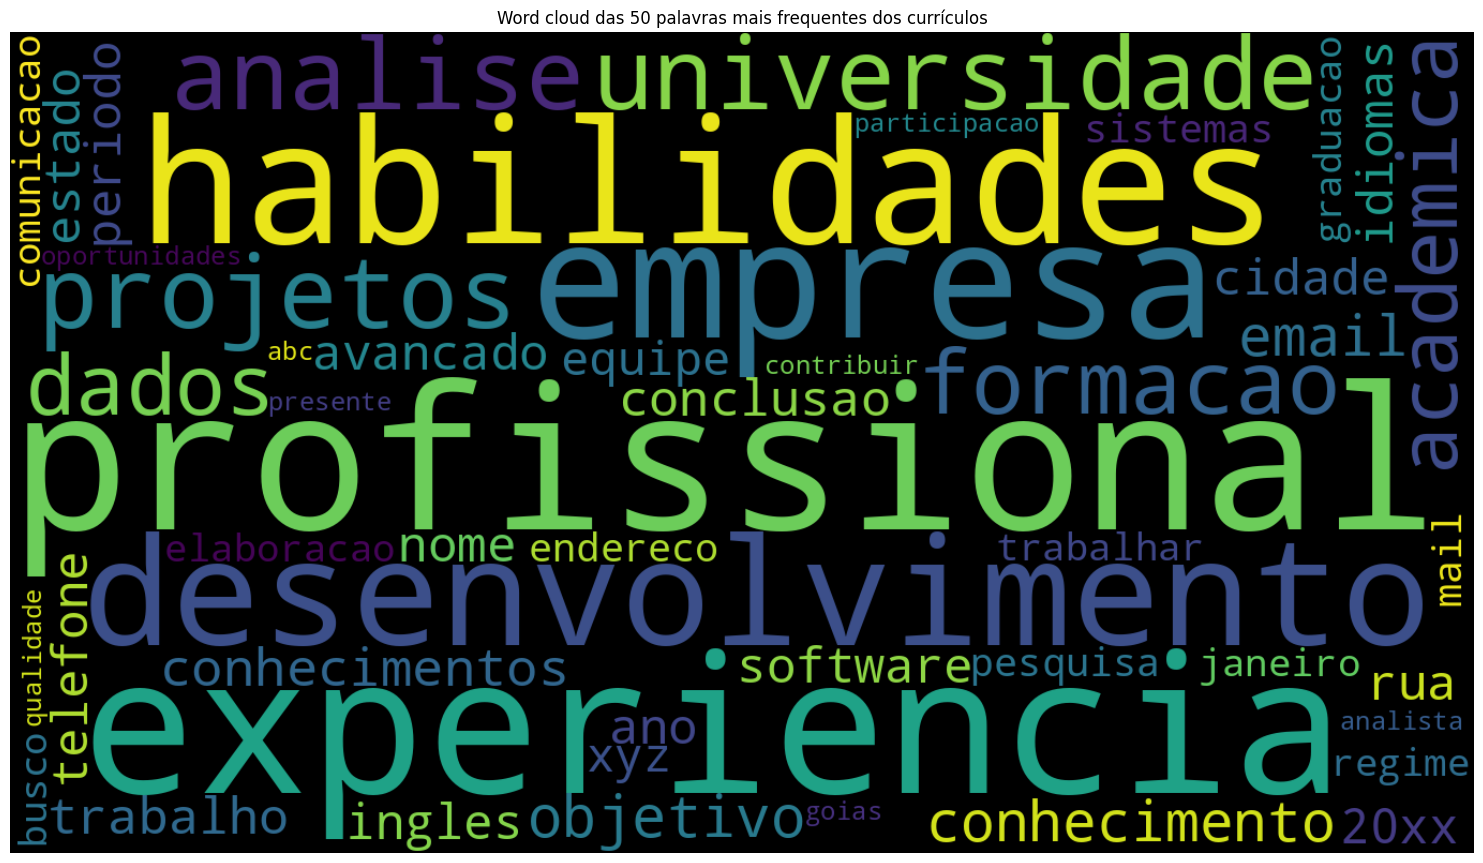

In [32]:
# Word cloud

# 'most_common' returns a list of (word, count) tuples
word_frequency = Counter(" ".join(
    [" ".join(curriculo) for curriculo in df_curriculos['curriculos']]).split()).most_common(50)

# cria um dicionário com os dados, necessário para a word cloud
frequencias = {tupla[0]: tupla[1] for tupla in word_frequency}

# inicializa uma word cloud
wordcloud = WordCloud(width=1366, height=766)

# gera uma wordcloud através do dicionário de frequências
wordcloud.generate_from_frequencies(frequencies=frequencias)

plt.figure(figsize=(15, 10))  # tamanho do gráfico, posso fazer facecolor='k'
# plotagem da nuvem de palavras
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud das 50 palavras mais frequentes dos currículos')
plt.tight_layout(pad=0)
plt.axis('off')  # remove as bordas
plt.show()  # mostra a word cloud


Text(0, 0.5, 'Frequência')

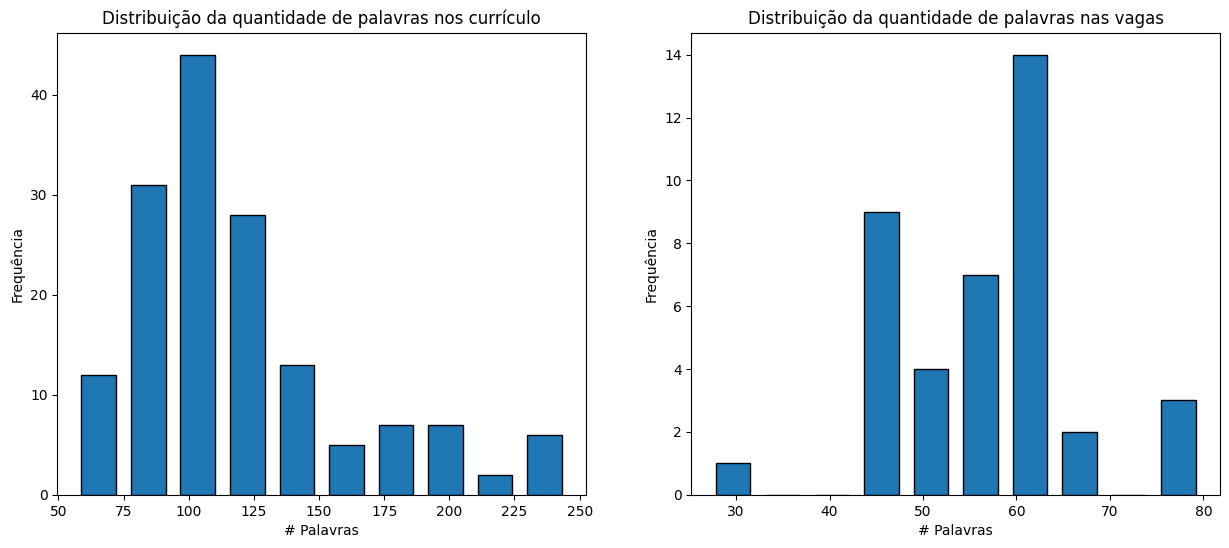

In [33]:
# Distribuição da quantidade de palavras

curriculos_len = [len(curriculo) for curriculo in df_curriculos['curriculos']]
vagas_len = [len(vaga) for vaga in df_vagas['textos']]

fig, axs = plt.subplots(1,2, figsize=(15, 6), dpi=100)
axs[0].hist(curriculos_len, rwidth=0.7, edgecolor='black')
axs[0].set_title('Distribuição da quantidade de palavras nos currículo')
axs[0].set_xlabel('# Palavras')
axs[0].set_ylabel('Frequência')

axs[1].hist(vagas_len, rwidth=0.7, edgecolor='black')
axs[1].set_title('Distribuição da quantidade de palavras nas vagas')
axs[1].set_xlabel('# Palavras')
axs[1].set_ylabel('Frequência')



In [34]:
# Análise de intersecção
# Pegar dicionario
tfv_curriculos = TfidfVectorizer(binary=True)
tfv_vagas = TfidfVectorizer(binary=True)
# Ajustar os pesos e fazer a transformação do corpus para a representação TF-IDF
tfidf_vagas = tfv_vagas.fit_transform(df_vagas['textos_stem'])
tfidf_vagas = pd.DataFrame.sparse.from_spmatrix(
    tfidf_vagas, columns=tfv_vagas.get_feature_names_out())

tfidf_curriculos = tfv_vagas.transform(df_curriculos['curriculos_stem'])
tfidf_curriculos = pd.DataFrame.sparse.from_spmatrix(
    tfidf_curriculos, columns=tfv_vagas.get_feature_names_out())



print(tfidf_curriculos.shape)
print(tfidf_vagas.shape)

(155, 580)
(40, 580)


In [150]:
# Análise de agrupamento pelo PCA

pca = PCA(n_components=2)
Xc = pca.fit_transform(tfidf_curriculos.sparse.to_dense())
fig = px.scatter(Xc, x=0, y=1, hover_name=df_curriculos['filenames'],
                 title=f'Análise de agrupamento dos currículos')

fig.update_traces(showlegend=False)
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(paper_bgcolor="LightSteelBlue")

fig.show()


In [149]:
# Análise de agrupamento pelo PCA

pca = PCA(n_components=2)
Xv = pca.fit_transform(tfidf_vagas.sparse.to_dense())
fig = px.scatter(Xv, x=0, y=1, hover_name=df_vagas['cargos'],
                 title=f'Análise de agrupamento das vagas')
fig.update_traces(showlegend=False, marker=dict(color='red'))
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(paper_bgcolor="LightSteelBlue")

fig.show()


In [147]:
# Análise de agrupamento pelo PCA

fig = make_subplots(rows=1, cols=2, subplot_titles=("Currículos", "Vagas"))

fig.add_trace(
    go.Scatter(x = Xc[:, 0], y= Xc[:, 1], hovertemplate=df_curriculos['filenames'], mode="markers", name="Currículos"),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x = Xv[:, 0], y= Xv[:, 1], hovertemplate=df_vagas['cargos'], mode="markers", name="Vagas"),
    row=1, col=2)

fig.update_layout( title_text="Análise de agrupamento",margin=dict(l=20,r=0,b=30,t=80), paper_bgcolor="LightSteelBlue",)


fig.show()


In [148]:
# Análise de agrupamento pelo PCA

fig = go.Figure(data=go.Scatter(
    x = Xc[:, 0],
    y= Xc[:, 1],
    mode="markers",
    name="Currículos",
    customdata=df_curriculos['filenames'],
    hovertemplate="<br>".join([
        "Currículo: %{customdata}",
        "x: %{x}",
        "y: %{y}",
    ])))

fig.add_scatter(x = Xv[:, 0],
                y= Xv[:, 1],
                mode="markers",
                name="Vagas",
                customdata=df_vagas['cargos'],
                hovertemplate="<br>".join([
                    "Vaga: %{customdata}",
                    "x: %{x}",
                    "y: %{y}",
                ]))

fig.update_layout(title_text="Análise de agrupamento", margin=dict(l=30,r=0,b=30,t=50),  paper_bgcolor="LightSteelBlue",)
fig.show()


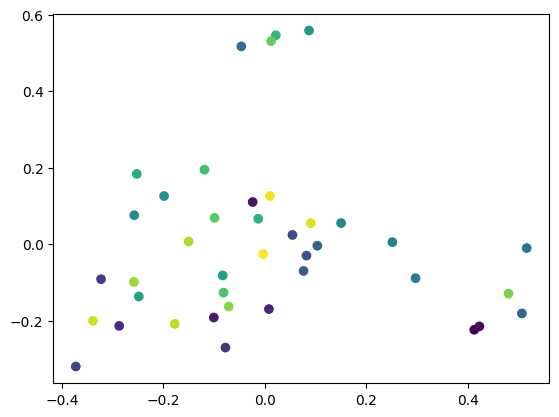

In [152]:
cores = [i for i in range(len(df_vagas['cargos']))]
pca = PCA(n_components=2)
Xt=pca.fit_transform(tfidf_vagas.sparse.to_dense())
plot = plt.scatter(Xt[:,0], Xt[:,1], c = cores)
plt.show()


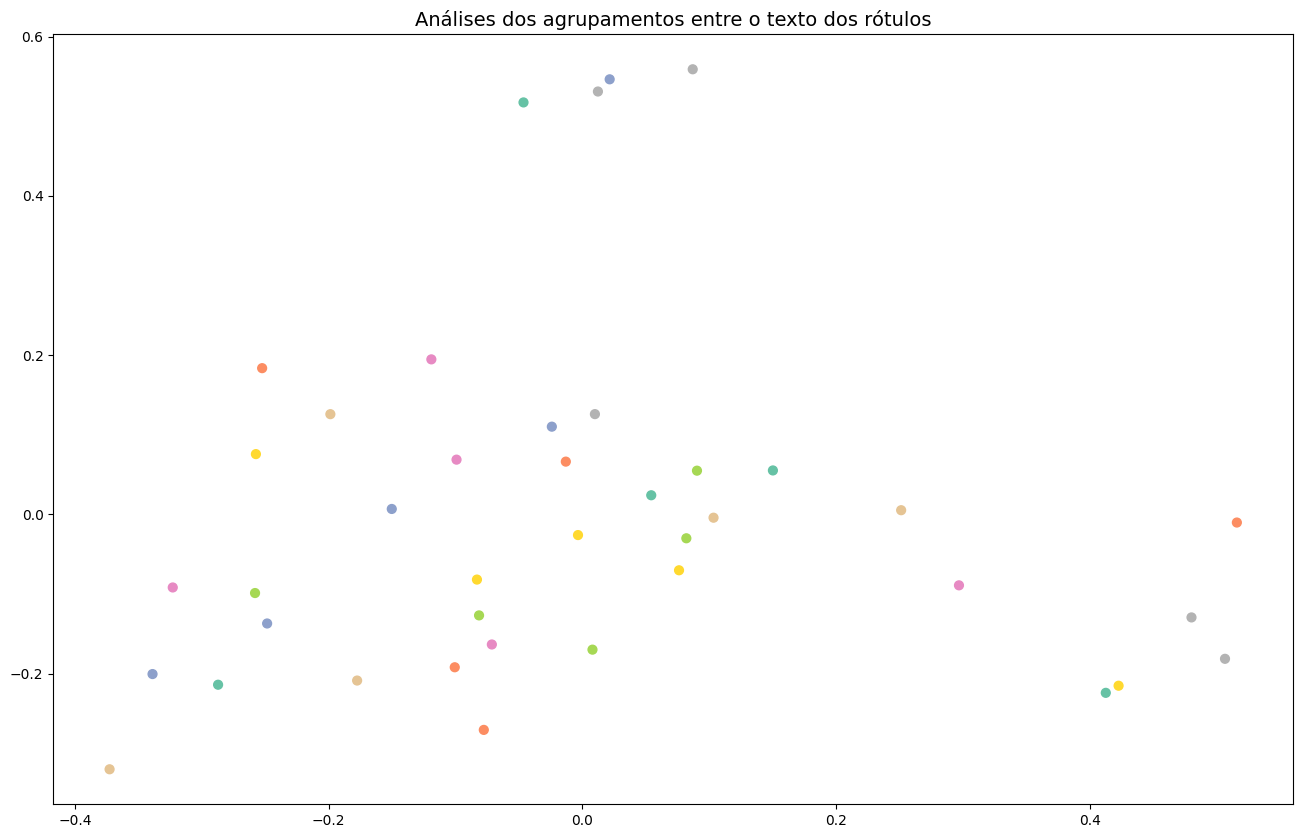

In [154]:
from sklearn.cluster import KMeans
n_clusters=40
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(tfidf_vagas)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(Xt[:,0], Xt[:,1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40)
plt.title('Análises dos agrupamentos entre o texto dos rótulos', fontsize=14);

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



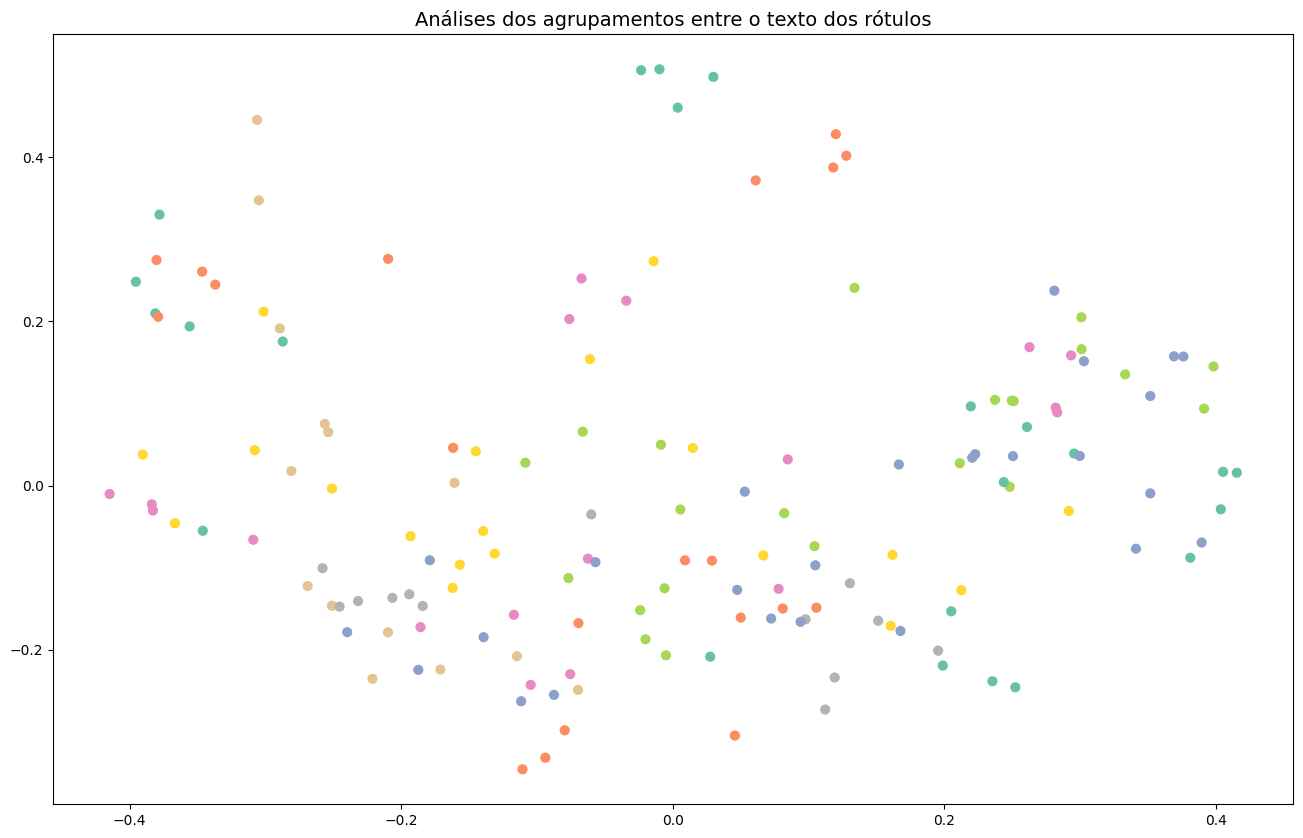

In [155]:
n_clusters=40
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(tfidf_curriculos)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(Xc[:,0], Xc[:,1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40)
plt.title('Análises dos agrupamentos entre o texto dos rótulos', fontsize=14);